In [1]:
### CONVERTS TRAJECTORY TO 4-STATE SPACE ###
### 1 Aug 2025 ###

import numpy as np

# Configuration
FORCE_FIELD = 'CHARMM27_TIP3P'
CV1_THRESH = 0.605   # nm 
CV2_THRESH = 0.485   # nm 

# State definitions from CV_array_generator
STATES = {
    1: 'C',   
    2: 'E',   
    3: 'NC',  
    4: 'N'    
}

def load_cv_data(force_field):
    """
    Load distance data from processed trajectory file.
    
    Args:
        force_field: String name of FF used in simulation
        
    Returns:
        numpy array with shape (n_frames, n_features) containing distance data
    """
    filename = f'CV_array_{force_field}.npy'
    cv_data = np.load(filename)
    return cv_data

def classify_states(cv_data, cv1_thresh, cv2_thresh):
    """
    Classify each frame into one of the four states.
    
    Uses a 2D classification scheme based on two key distance measurements:
    - CV1 (column 0)
    - CV2 (column 2)
    
    Args:
        cv_data: Array of collective variable data (distances)
        cv1_thresh: Threshold distance for CV1
        cv2_thresh: Threshold distance for CV2
        
    Returns:
        Array of state classifications (1-4) for each frame
    """
    # Extract the two key distance measurements from the data
    cv1 = cv_data[:, 0]  # column 0
    cv2 = cv_data[:, 2]  # column 2
    
    # Initialize result array - start with all zeros
    states = np.zeros(len(cv_data), dtype=int)
    
    # Apply 2D state classification rules based on distance thresholds
    # State 1 (C): CV1 long AND CV2 short
    states[(cv1 > cv1_thresh) & (cv2 < cv2_thresh)] = 1  
    # State 2 (E): CV1 long AND CV2 long  
    states[(cv1 > cv1_thresh) & (cv2 > cv2_thresh)] = 2  
    # State 3 (NC ): CV1 short AND CV2 short
    states[(cv1 < cv1_thresh) & (cv2 < cv2_thresh)] = 3  
    # State 4 (N): CV1 short AND CV2 long
    states[(cv1 < cv1_thresh) & (cv2 > cv2_thresh)] = 4  
    
    return states

def save_and_report(states, force_field):
    """
    Save state classifications to file and print detailed statistics.
    
    Args:
        states: Array of state classifications for each frame
        force_field: String name of force field for filename
    """
    # Save the state classifications to a numpy file
    output_file = f'04_states_array_{force_field}.npy'
    np.save(output_file, states)
    
    # Calculate statistics for each state
    counts = np.bincount(states, minlength=5)[1:]  # Count occurrences, exclude state 0
    total_frames = len(states)
    proportions = counts / total_frames  # Convert to percentages
    
    # Print detailed report
    print(f"--- State Classifications for {force_field} ---")
    print(f"Total frames analyzed: {total_frames}")
    print("\nState populations:")
    
    # Loop through each state and report statistics
    for i, (state_num, state_name) in enumerate(STATES.items()):
        print(f"State {state_num} ({state_name:2s}): {counts[i]:6d} frames ({proportions[i]:6.2%})")
    
    # Print summary information
    print("\n" + "="*40)
    print(f"Shape of saved states array: {states.shape}")
    print(f"Saved to: {output_file}")

def main():
    """
    Main analysis pipeline to classify states.
    
    This script:
    1. Loads processed distance data 
    2. Classifies each frame into one of 4 conformational states
    3. Saves results and prints statistics
    """
    # Step 1: Load the processed collective variable (distance) data
    print("Loading collective variable data...")
    cv_data = load_cv_data(FORCE_FIELD)
    print(f"Loaded data with shape: {cv_data.shape}")
    
    # Step 2: Classify each frame into conformational states
    print(f"\nClassifying states using thresholds:")
    print(f"  CV1 threshold: {CV1_THRESH} nm")
    print(f"  CV2 threshold: {CV2_THRESH} nm")
    states = classify_states(cv_data, CV1_THRESH, CV2_THRESH)
    
    # Step 3: Save results and generate report
    print(f"\nProcessing complete!")
    save_and_report(states, FORCE_FIELD)

# Run the analysis if this script is executed directly
if __name__ == "__main__":
    main()

Loading collective variable data...
Loaded data with shape: (25000000, 4)

Classifying states using thresholds:
  CV1 threshold: 0.605 nm
  CV2 threshold: 0.485 nm

Processing complete!
--- State Classifications for CHARMM27_TIP3P ---
Total frames analyzed: 25000000

State populations:
State 1 (C ): 4541891 frames (18.17%)
State 2 (E ): 4004059 frames (16.02%)
State 3 (NC): 8569102 frames (34.28%)
State 4 (N ): 7884946 frames (31.54%)

Shape of saved states array: (25000000,)
Saved to: 04_states_array_CHARMM27_TIP3P.npy


Loading collective variable data...
Loaded data with shape: (25000000, 4)
Features: CV1, CV1a, CV2, CV2a

Classifying states using distance thresholds:
  CV1 threshold:  0.605 nm
  CV1a threshold: 0.846 nm
  CV2 threshold:  0.487 nm
  CV2a threshold: 0.607 nm

Processing complete!
--- 16-State Classifications for CHARMM27_TIP3P ---
Total frames analyzed: 25000000

State populations (Binary -> Decimal -> Count -> Percentage):
Format: CV1 - CV1a - CV2 - CV2a
------------------------------------------------------------
0000 ->  0 ->  4321448 ->  17.29%
0001 ->  1 ->      638 ->   0.00%
0010 ->  2 ->  1848555 ->   7.39%
0011 ->  3 ->  1710731 ->   6.84%
0100 ->  4 ->  4249885 ->  17.00%
0101 ->  5 ->      256 ->   0.00%
0110 ->  6 ->  2635387 ->  10.54%
0111 ->  7 ->  1687148 ->   6.75%
1000 ->  8 ->   997259 ->   3.99%
1001 ->  9 ->       43 ->   0.00%
1010 -> 10 ->   519879 ->   2.08%
1011 -> 11 ->   596706 ->   2.39%
1100 -> 12 ->  3546041 ->  14.18%
1101 -> 13 ->      289 ->   0.00%
11

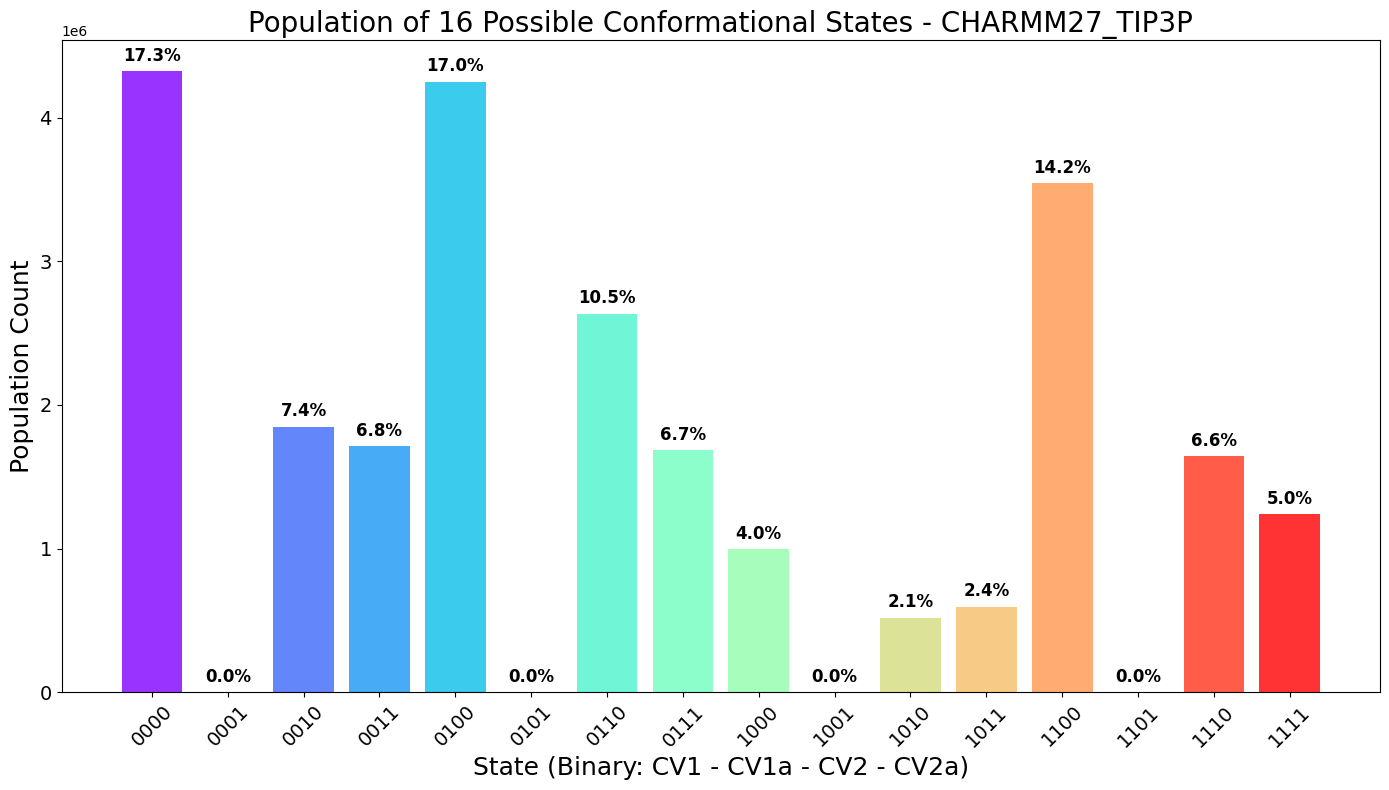

In [2]:
### CONVERTS TRAJECTORY TO 16-STATE SPACE ###
### 1 Aug 2025 ###

import numpy as np
import matplotlib.pyplot as plt

# Configuration
FORCE_FIELD = 'CHARMM27_TIP3P'

# Distance thresholds for each of the 4 collective variables (in nm)
# These cutoffs divide each distance into "short" (below) or "long" (above) categories

CUTOFFS = [0.605, 0.846, 0.487, 0.607]  # Thresholds for CV1, CV1a, CV2, CV2a respectively

def load_cv_data(force_field):
    """
    Load distance data from processed trajectory file.
    
    Args:
        force_field: String name of FF used in simulation
        
    Returns:
        numpy array with shape (n_frames, 4) containing distance data for CV1, CV1a, CV2, CV2a
    """
    filename = f'CV_array_{force_field}.npy'
    cv_data = np.load(filename)
    return cv_data

def classify_16_states(cv_data, cutoffs):
    """
    Classify each simulation frame into one of 16 states using binary encoding.
    
    This creates a 4-dimensional state space where each collective variable (distance)
    is classified as either "short" (0) or "long" (1) relative to its threshold.
    The combination of 4 binary values (2^4) gives 16 possible states.
    
    Binary encoding scheme:
    - CV1:  0 = below threshold, 1 = above threshold (contributes 8 to decimal value)
    - CV1a: 0 = below threshold, 1 = above threshold (contributes 4 to decimal value)  
    - CV2:  0 = below threshold, 1 = above threshold (contributes 2 to decimal value)
    - CV2a: 0 = below threshold, 1 = above threshold (contributes 1 to decimal value)
    
    Args:
        cv_data: Array of collective variable data with shape (n_frames, 4)
        cutoffs: List of 4 threshold values for binary classification [CV1, CV1a, CV2, CV2a]
        
    Returns:
        Array of state indices (0-15) for each frame
    """
    n_frames = cv_data.shape[0]
    
    # STEP 1: Convert continuous distances to binary "short/long" classifications
    # =====================================================================
    # Turn 4 continuous distance measurements into a simple "short" (0) or "long" (1) classification for each distance.
    #
    # This creates a 2D array where each row is a time frame and each column
    # represents whether that distance is short (0) or long (1)
    
    binary_states = np.zeros((n_frames, 4), dtype=int)
    
    # Loop through each collective variable and apply binary classification
    for i, cutoff in enumerate(cutoffs):
        cv_column = cv_data[:, i]  # Extract all distance values for this CV
        
        # For every frame: is this distance >= threshold? 
        # If YES → 1 (long), if NO → 0 (short)
        binary_states[:, i] = (cv_column >= cutoff).astype(int)
    
    # STEP 2: Convert binary combinations to unique state numbers (0-15)
    # ================================================================
    # Now we have 4 binary values (0 or 1) for each frame. There are 2^4 = 16 
    # possible combinations. We convert these to decimal numbers 0-15.
    #
    # Like a 4-digit binary number being converted to decimal.
    # For example: if CV1=long, CV1a=short, CV2=short, CV2a=long
    # Binary: [1, 0, 0, 1] → Decimal: 1×8 + 0×4 + 0×2 + 1×1 = 9
    #
    # Each CV gets a "binary place value":
    # - CV1:  contributes 8 if long (like the "8s place" in binary: 2^3 = 8)
    # - CV1a: contributes 4 if long (like the "4s place" in binary: 2^2 = 4)  
    # - CV2:  contributes 2 if long (like the "2s place" in binary: 2^1 = 2)
    # - CV2a: contributes 1 if long (like the "1s place" in binary: 2^0 = 1)
    #
    # RESULT: Every unique combination of short/long distances gets a unique number
    
    state_indices = (binary_states[:, 0] * 8 +   # CV1 contribution (2^3)
                    binary_states[:, 1] * 4 +    # CV1a contribution (2^2)
                    binary_states[:, 2] * 2 +    # CV2 contribution (2^1)
                    binary_states[:, 3])         # CV2a contribution (2^0)
    
    return state_indices

def save_and_report(states, force_field):
    """
    Save state classifications to file and print comprehensive statistics.
    
    Args:
        states: Array of state classifications (0-15) for each frame
        force_field: String name of force field for filename
        
    Returns:
        populations: Array containing count of frames in each state
    """
    # Save the state classifications to a numpy file
    output_file = f'16_states_array_{force_field}.npy'
    np.save(output_file, states)
    
    # Count how many frames belong to each of the 16 possible states
    populations = np.bincount(states, minlength=16)
    total_frames = len(states)
    
    # Print detailed report showing binary -> decimal -> count -> percentage
    print(f"--- 16-State Classifications for {force_field} ---")
    print(f"Total frames analyzed: {total_frames}")
    print("\nState populations (Binary -> Decimal -> Count -> Percentage):")
    print("Format: CV1 - CV1a - CV2 - CV2a")
    print("-" * 60)
    
    # Loop through all 16 possible states and report statistics
    for i in range(16):
        binary = f"{i:04b}"  # Convert decimal to 4-digit binary string
        percentage = (populations[i] / total_frames) * 100
        print(f"{binary} -> {i:2d} -> {populations[i]:8d} -> {percentage:6.2f}%")
    
    # Print summary information
    print("\n" + "="*40)
    print(f"Shape of saved states array: {states.shape}")
    print(f"Saved to: {output_file}")
    
    return populations

# THIS FIGURE IS NOT IN THE PUBLICATION, JUST A SANITY CHECK

def plot_state_populations(populations, total_frames, force_field):
    """
    Create a rainbow-colored bar graph showing population of each state.
    
    Args:
        populations: Array of frame counts for each state
        total_frames: Total number of simulation frames
        force_field: String name of force field for plot title
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 8))
    
    x_labels = [f"{i:04b}" for i in range(16)]  # 0000, 0001, 0010, etc.
    x_positions = range(16)
    colors = plt.cm.rainbow(np.linspace(0, 1, 16))
    bars = ax.bar(x_positions, populations, alpha=0.8, color=colors)
    ax.set_xlabel('State (Binary: CV1 - CV1a - CV2 - CV2a)', fontsize=18)
    ax.set_ylabel('Population Count', fontsize=18)
    ax.set_title(f'Population of 16 Possible Conformational States - {force_field}', fontsize=20)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=45, fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    # Add percentage labels on top of bars for states with non-zero population
    for i, (bar, pop) in enumerate(zip(bars, populations)):
        if pop > 0.1:  # Only label bars that have some population
            percentage = (pop / total_frames) * 100
            # Position label slightly above the bar
            ax.text(bar.get_x() + bar.get_width()/2, 
                   bar.get_height() + max(populations)*0.01,
                   f'{percentage:.1f}%', 
                   ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Adjust layout to prevent label cutoff and display the plot
    plt.tight_layout()
    plt.show()

# RUN

def main():
    """
    16-state classification.
    
    This script:
    1. Loads processed distance data for 4 collective variables (CV1, CV1a, CV2, CV2a)
    2. Classifies each frame into one of 16 binary-encoded states
    3. Saves results, prints detailed statistics, and creates visualization
    """
    # Step 1: Load the processed collective variable (distance) data
    print("Loading collective variable data...")
    cv_data = load_cv_data(FORCE_FIELD)
    print(f"Loaded data with shape: {cv_data.shape}")
    print(f"Features: CV1, CV1a, CV2, CV2a")
    
    # Step 2: Classify each frame using binary encoding of all 4 distances
    print(f"\nClassifying states using distance thresholds:")
    print(f"  CV1 threshold:  {CUTOFFS[0]} nm")
    print(f"  CV1a threshold: {CUTOFFS[1]} nm") 
    print(f"  CV2 threshold:  {CUTOFFS[2]} nm")
    print(f"  CV2a threshold: {CUTOFFS[3]} nm")
    
    states = classify_16_states(cv_data, CUTOFFS)
    
    # Step 3: Save results, generate detailed report, and create visualization
    print(f"\nProcessing complete!")
    populations = save_and_report(states, FORCE_FIELD)
    
    # Step 4: Create a visual representation of state populations
    print("\nGenerating visualization...")
    plot_state_populations(populations, len(states), FORCE_FIELD)

# Run the analysis if this script is executed directly
if __name__ == "__main__":
    main()